<a href="https://colab.research.google.com/github/moritzgeiger/sheet-counter/blob/master/notebooks/mg_sheet_count_model_colab_210516.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Counting Metal Sheets with CNN Methods -Part II- <a class='tocSkip'>"

**Contributors**: Moritz Geiger

# Imports

In [ ]:
!git clone https://github.com/moritzgeiger/sheet-counter.git

Cloning into 'sheet-counter'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 7), reused 36 (delta 1), pack-reused 0
Unpacking objects: 100% (42/42), done.


In [2]:
import pandas as pd
import numpy as np
import requests
from io import StringIO, BytesIO
import os
from shutil import copyfile
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL
import seaborn as sns
# import tensorflow as tf
# from tensorflow.keras import Sequential, layers
# from google.colab import files
# from google.colab import drive
from sklearn.model_selection import train_test_split

## Sources

- Paper about counting from air (trees, cars): [https://arxiv.org/pdf/2102.04366v1.pdf](https://arxiv.org/pdf/2102.04366v1.pdf)
- more info on regression based methods: [https://arxiv.org/pdf/2007.01899v2.pdf](https://arxiv.org/pdf/2007.01899v2.pdf)
- basic model to count fingers: [https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/](https://analyticsindiamag.com/how-to-implement-cnn-model-to-count-fingers-and-distinguish-between-left-and-right-hand/)
- How neural networks work: [https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480](https://towardsdatascience.com/the-most-intuitive-and-easiest-guide-for-convolutional-neural-network-3607be47480)
- load training dataset for rsoc: [https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method](https://github.com/gaoguangshuai/Counting-from-Sky-A-Large-scale-Dataset-for-Remote-Sensing-Object-Counting-and-A-Benchmark-Method)
- Guide for CNN with pytorch: [https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce](https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce)

# Loading images

In [2]:
## load all filenames (COLAB SPECIFIC)
drive.mount('/sheet_count')

Mounted at /sheet_count


In [3]:
## load all filenames (COLAB SPECIFIC)
newpath = '/sheet_count/MyDrive/sheet_count/originals'
final_imgs = [os.path.join(newpath, img) for img in os.listdir(newpath)]
final_imgs

['/sheet_count/MyDrive/sheet_count/originals/1_00mm_29_91_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_36_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_20_21_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_40_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_16_21_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_24_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_7_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_6_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_43_159_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_31_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_41_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_46_152_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_42_154_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/originals/1_00mm_0_-99_fin.jpg',
 '/sheet_count/MyDrive/sheet_count/origi

**Note**<br>
The filenames have the following structure:<br>
```[thickness]_[id]_[sheetcount/target]_[<fin>].jpg```

In [5]:
print(f'The dataset consists of \033[1m{len(final_imgs)}\033[0m images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.')
 

The dataset consists of 49 images. Some of which are not counted ("-99") due to blurryness. That might be of interest for further analysis.


# Exploring the dataset

The images show amateur photographs of metal sheet stacks on pallets in a warehouse during daylight conditions. The data provided contains metal sheets of sizes 0.75mm to 1.5mm. The sheets are either perforated or expanded. The perforated sheets lie horizontally on top of each other. The expanded metal forms a wavy profile when stacked.

## Examples

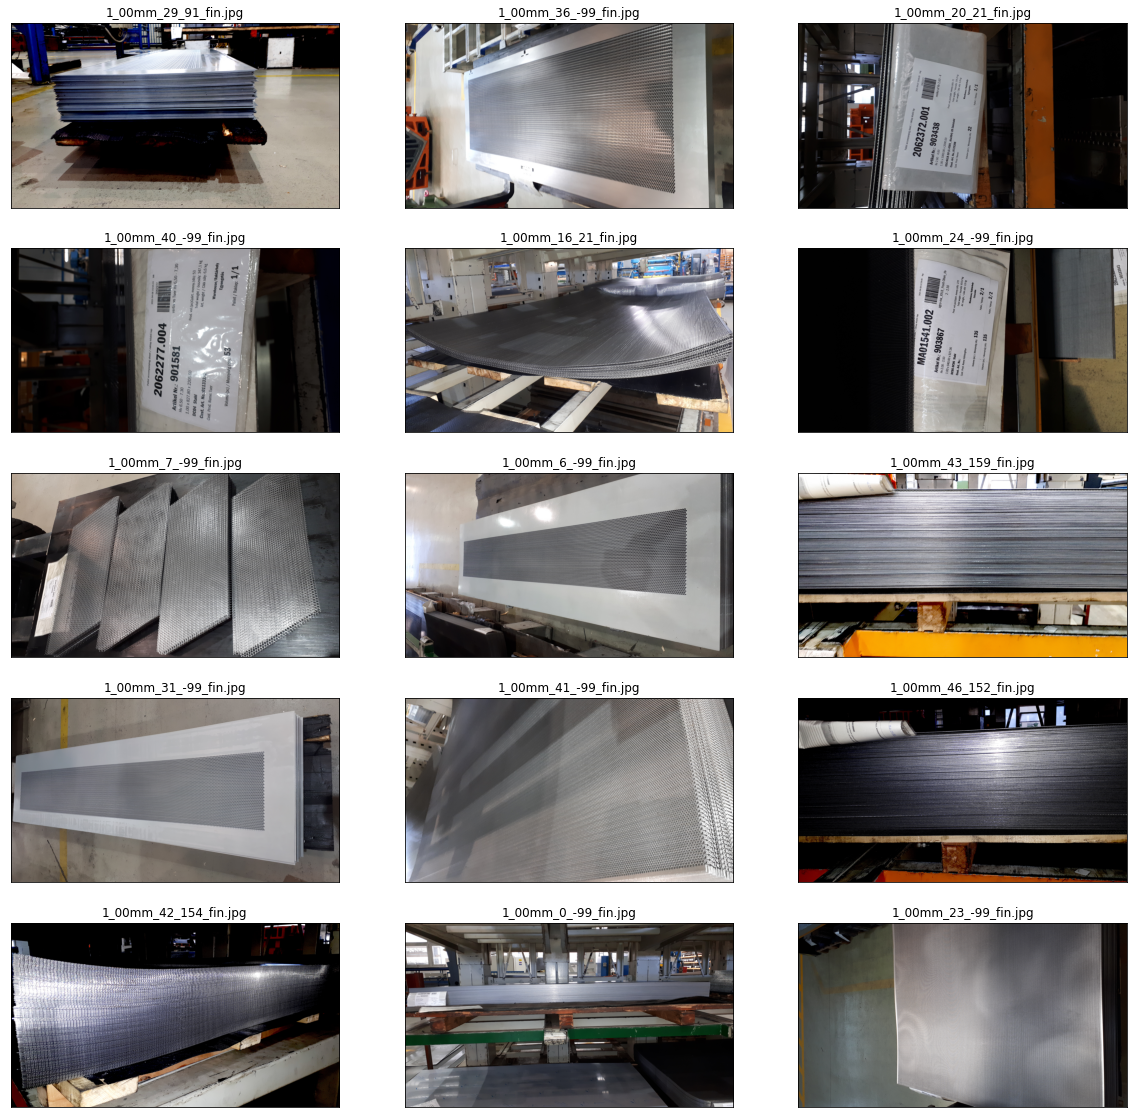

In [6]:
# showcasing some img examples
fig = plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.title(f'img_{i}', size=12)
    plt.title(final_imgs[i].split("/")[-1], size=12)
    plt.imshow(mpimg.imread(final_imgs[i]))
    plt.xticks(())
    plt.yticks(())

## Image quality

As visible, some of the images are not usable due to blurryness wrong angles. They would add too much noise to the model and will be manually sorted out of the data set. The optimal image should show the sheet stack from the side with enough light to detect the contrast between the sheets.
Note

The images are removed. They will be useful in case a decision/classifying layer should be implemented of whether to use an image or not. 

In [7]:
## find img resolutions
sizes = []
for img in final_imgs:
    if 'jpg' in img:
        im = PIL.Image.open(img)
        sizes.append(im.size)

In [8]:
# all images have the same resolution
print(f'The resolution of all images is: \033[1m{sizes[0][0]}x{sizes[0][1]}px\033[0m')

The resolution of all images is: 4608x2592px


**Note**<br>
Looking at the upcoming steps it will be inevitable to crop the images to their most important part. This will be done manually, but can also be implemented later on in a subsequential automatized pre process.

## Cropped imgs

In [9]:
# loading cropped images
cropped_path = '/sheet_count/MyDrive/sheet_count/cropped'
cropped_imgs = [os.path.join(cropped_path, img) for img in os.listdir(cropped_path)]
# cropped_imgs

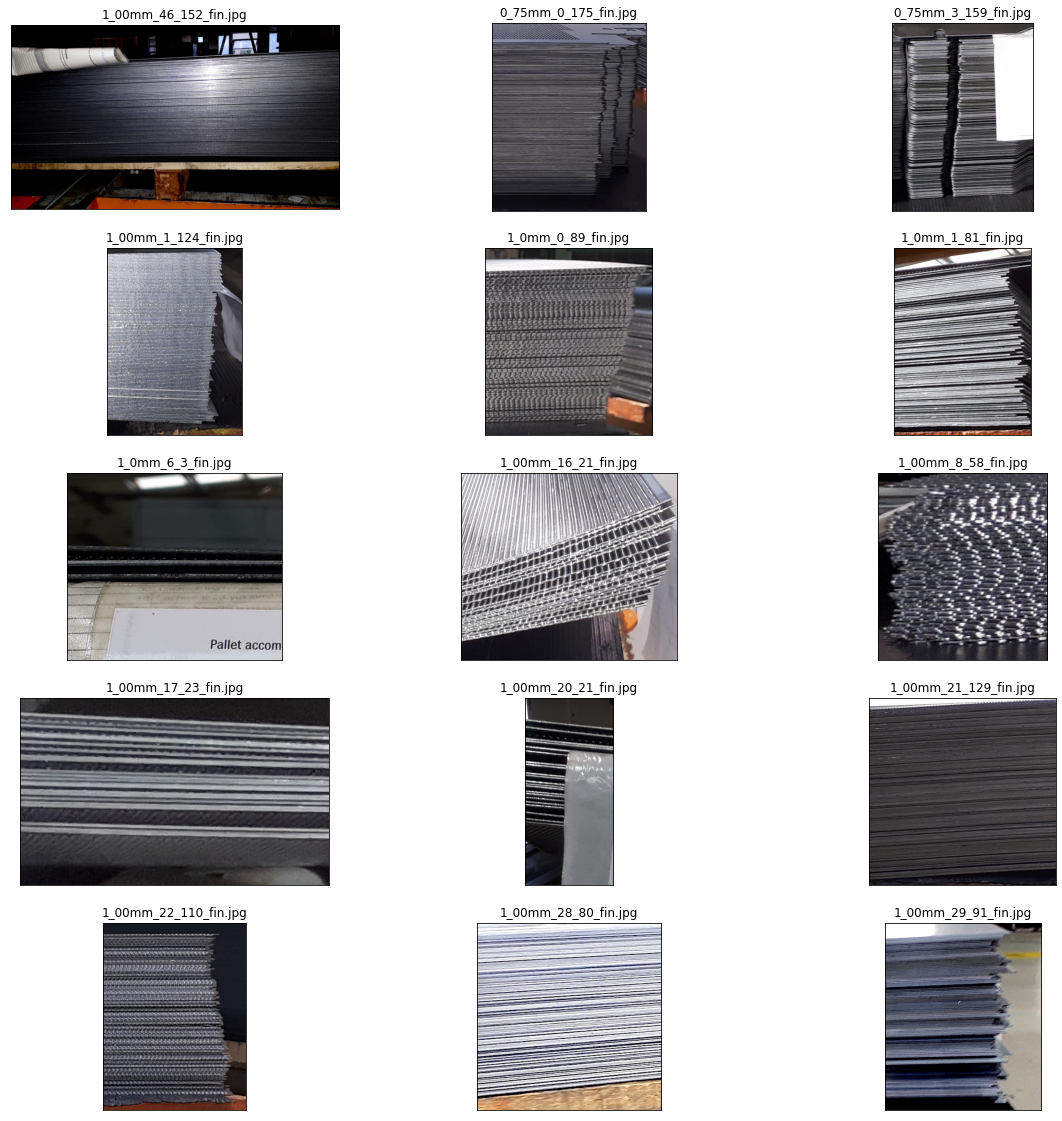

In [10]:
# showcasing some cropped img examples
fig = plt.figure(figsize=(20,20))
for i in range(15):
    plt.subplot(5, 3, i+1)
    plt.title(f'img_{i}', size=12)
    plt.title(cropped_imgs[i].split("/")[-1], size=12)
    plt.imshow(mpimg.imread(cropped_imgs[i]))
    plt.xticks(())
    plt.yticks(())

## Target Range

In [11]:
## turning data into DF
img_dict = {'filepath':[],
            'thickness':[],
            'target':[],
           }
for img in cropped_imgs:
    splt = img.split('_')
    img_dict['filepath'].append(img)
    img_dict['thickness'].append(f'{splt[-5].split("/")[-1]}.{splt[-4]}')
    img_dict['target'].append(splt[-2])
    
img_df = pd.DataFrame(img_dict)
img_df['target'] = pd.to_numeric(img_df['target'])

In [12]:
# minor measurement cleaning
img_df['thickness'] = img_df['thickness'].replace({'1.0mm': '1.00mm'})

In [13]:
# showcase DF
img_df.sort_values(by='thickness', ascending=False).head(10)

filepath thickness  target
52  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm     105
38  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm      58
29  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm     109
30  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm     120
31  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm      69
32  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm     120
33  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm     120
34  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm      23
35  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm      36
36  /sheet_count/MyDrive/sheet_count/cropped/1_5mm...     1.5mm      36

In [14]:
img_df.dtypes

filepath     object
thickness    object
target        int64
dtype: object

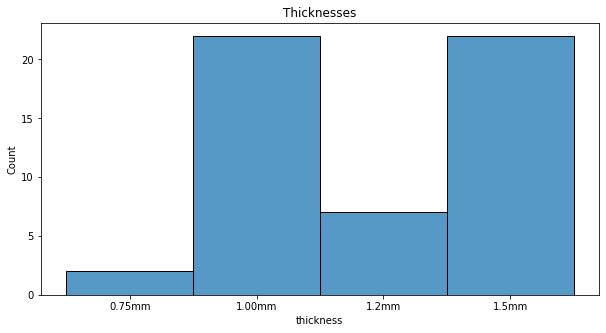

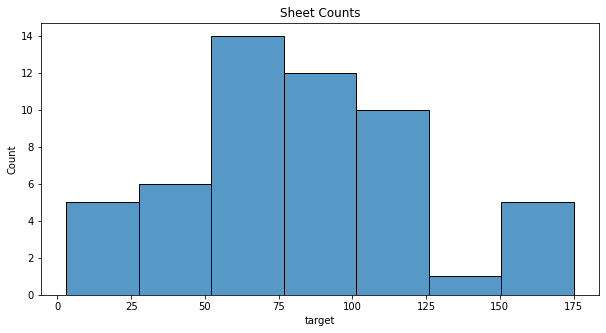

In [15]:
# distribution of dataset
plt.figure(1, figsize=(10,5))
plt.title('Thicknesses')
sns.histplot(data=img_df.thickness.sort_values())

plt.figure(2, figsize=(10,5))
plt.title('Sheet Counts')
sns.histplot(data=img_df.target.sort_values())

In [16]:
# Range of counts
img_df[img_df['target']>0].target.describe()

count     53.000000
mean      82.000000
std       39.580007
min        3.000000
25%       56.000000
50%       80.000000
75%      109.000000
max      175.000000
Name: target, dtype: float64

# IMG preprocessing

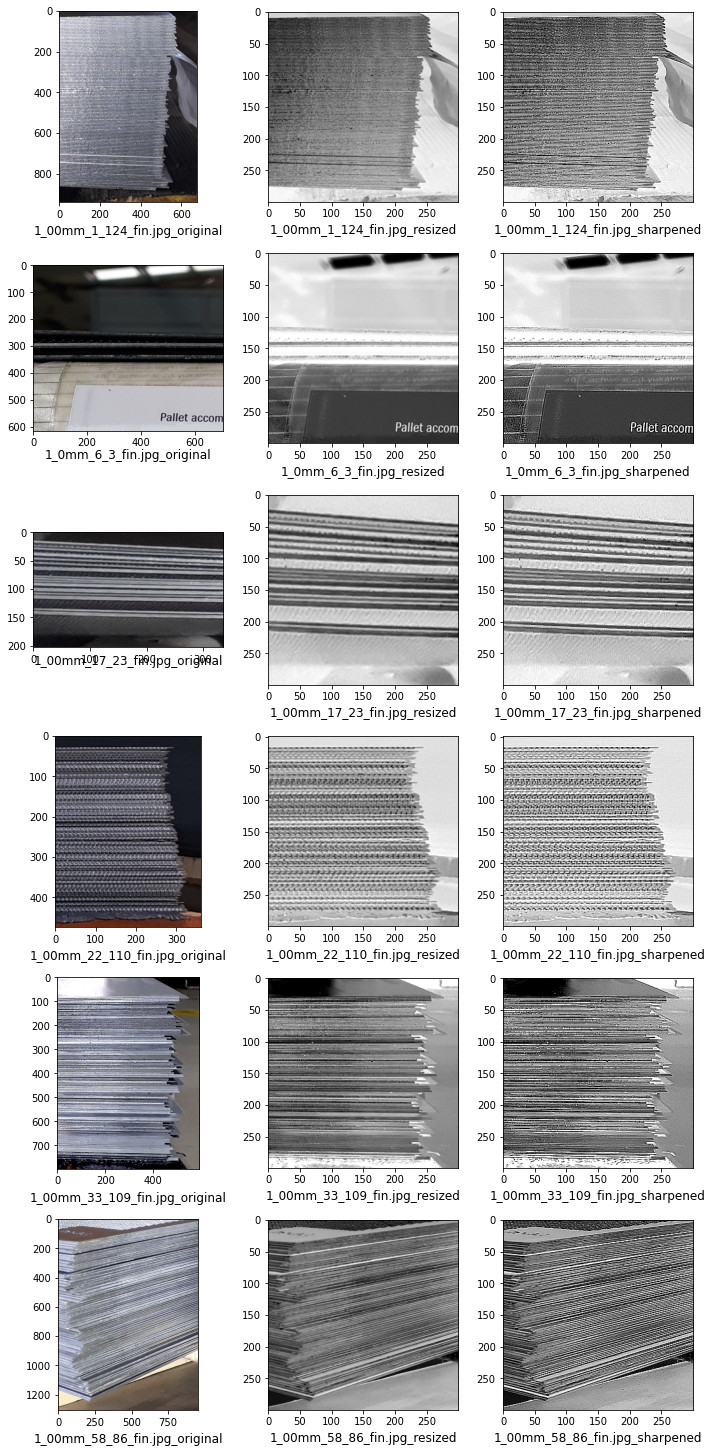

In [17]:
 from PIL import ImageOps
# showcasing if resizing and grayscaling is possible
fig = plt.figure(figsize=(10,50))
# setting up 3 columns
for i in range(3,21,3):
    im = PIL.Image.open(cropped_imgs[i])

    # without sharpening
    im = im.resize((300,300))
    im = ImageOps.grayscale(im)
    a = np.asarray(im)
    plt.subplot(15, 3, i-1)
    plt.title(f'{cropped_imgs[i].split("/")[-1]}_resized', size=12, y=-.2)
    plt.imshow(a, cmap=plt.cm.binary)

    # sharpening image 2x
    sharpened = im.filter(PIL.ImageFilter.SHARPEN)
    sharpened = sharpened.filter(PIL.ImageFilter.SHARPEN)
    sharpened = sharpened.resize((300,300))
    sharpened = ImageOps.grayscale(sharpened)
    b = np.asarray(sharpened)
    plt.subplot(15, 3, i)
    plt.title(f'{cropped_imgs[i].split("/")[-1]}_sharpened', size=12, y=-.2)
    plt.imshow(b, cmap=plt.cm.binary)

    # original
    plt.subplot(15, 3, i-2)
    plt.title(f'{cropped_imgs[i].split("/")[-1]}_original', size=12, y=-.2)
    plt.tight_layout()
    plt.imshow(mpimg.imread(cropped_imgs[i]))


**Note**<br>
It seems that resizing the images does not harm the images quality. It might even improve the readability of some images by expanding the countable layers graphically. Sharpening also adds contrast to the image. Therefore we will use it for further modelling.

In [18]:
# Applying resizing, grayscaling and encoding to all images in dataset
def resize_store(img_dict):
    paths = img_dict.get('filepath')
    img_dict['imarray'] = []
    for path in paths:
        im = PIL.Image.open(path)
        sharpened = im.filter(PIL.ImageFilter.SHARPEN)
        sharpened = sharpened.filter(PIL.ImageFilter.SHARPEN)
        sharpened = sharpened.resize((300,300))
        sharpened = ImageOps.grayscale(sharpened)
        a = np.asarray(sharpened)
        img_dict['imarray'].append(a)
    return img_dict

In [24]:
df_array = pd.DataFrame(resize_store(img_dict))
# df_array

In [20]:
len(df_array.imarray[0])

300

# Train test split

In [27]:
X = df_array[['imarray']]
y = df_array[['target']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [30]:
X_train.shape, X_test.shape

((35, 1), (18, 1))

In [31]:
# more suggestions:
## image augmentation
## use the classification-then-regression trick
# 

# Model

In [36]:
from tensorflow.keras import models
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras.layers import Dense, Reshape

#### 1. ARCHITECTURE
model = Sequential()
# model.add() # Flattenning of a 300*300 image with 1 color
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(layers.Dense(4, activation='relu')) # linear regression

# Regression
adam_opt = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)
model.compile(loss='mse', 
              optimizer=adam_opt,
              metrics=['mae'])

es = callbacks.EarlyStopping(patience=30, restore_best_weights=True)

model.fit(X_train, y_train,
          batch_size=16, # Too small --> no generalization. Too large --> compute slowly
          epochs=100,
          validation_split=0.3,
          callbacks=[es],
          verbose=0)

ValueError: ignored

In [ ]:
print(model.evaluate(X_test, y_test))